In [1]:
!pip install torchmetrics

     |████████████████████████████████| 332 kB 4.7 MB/s 


In [2]:
import zipfile
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
import torch
import torch.nn as nn
import torch.optim as optim
import math
from torchmetrics.functional import accuracy
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt



## Подготовка данных

In [3]:
!wget https://github.com/jeka-e/seminars/blob/master/Fake.csv.zip?raw=true


--2021-12-22 15:05:44--  https://github.com/jeka-e/seminars/blob/master/Fake.csv.zip?raw=true
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/jeka-e/seminars/raw/master/Fake.csv.zip [following]
--2021-12-22 15:05:45--  https://github.com/jeka-e/seminars/raw/master/Fake.csv.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jeka-e/seminars/master/Fake.csv.zip [following]
--2021-12-22 15:05:45--  https://raw.githubusercontent.com/jeka-e/seminars/master/Fake.csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2398255

In [4]:
with zipfile.ZipFile('/content/Fake.csv.zip?raw=true', 'r') as zip_ref:
    zip_ref.extract('Fake.csv')
fake = pd.read_csv('Fake.csv')

In [34]:
fake.subject.value_counts() #очень неравномерное распределение, причем непонятно, чем news отличается от left-news, например

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

In [35]:
len(fake)

23481

In [36]:
news=fake[['text','subject']]
cat_mapper = {cat: n for n, cat in enumerate(news.subject.unique())}
news.subject = news.subject.map(cat_mapper)
news['label'] = news['subject']
news = news.drop(columns=['subject'])
news.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,text,label
0,Donald Trump just couldn t wish all Americans ...,0
1,House Intelligence Committee Chairman Devin Nu...,0
2,"On Friday, it was revealed that former Milwauk...",0
3,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis used his annual Christmas Day mes...,0


В статье в препроцессинге они делают только сведение к нижнему регистру. Я еще удалю пунктуацию, потому что в статье они решают задачу сантимент анализа, так что пунтктуация очень важна; для нашей же задачи она, кажется, не особо влияет. Оставлю только цифры (мб важно для новости) и буквы.

In [37]:
# REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;!.?-]')
to_remove = re.compile('[^a-z0-9 ]')
def preprocessing(text):
    text = text.lower()  
    text = to_remove.sub('', text)
    return text

In [38]:
news.text = news.text.apply(preprocessing)
news.head()

,text,label
0,donald trump just couldn t wish all americans ...,0
1,house intelligence committee chairman devin nu...,0
2,on friday it was revealed that former milwauke...,0
3,on christmas day donald trump announced that h...,0
4,pope francis used his annual christmas day mes...,0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
Epoch 6: 8960it [01:30, 98.74it/s, train_loss=1.42] 


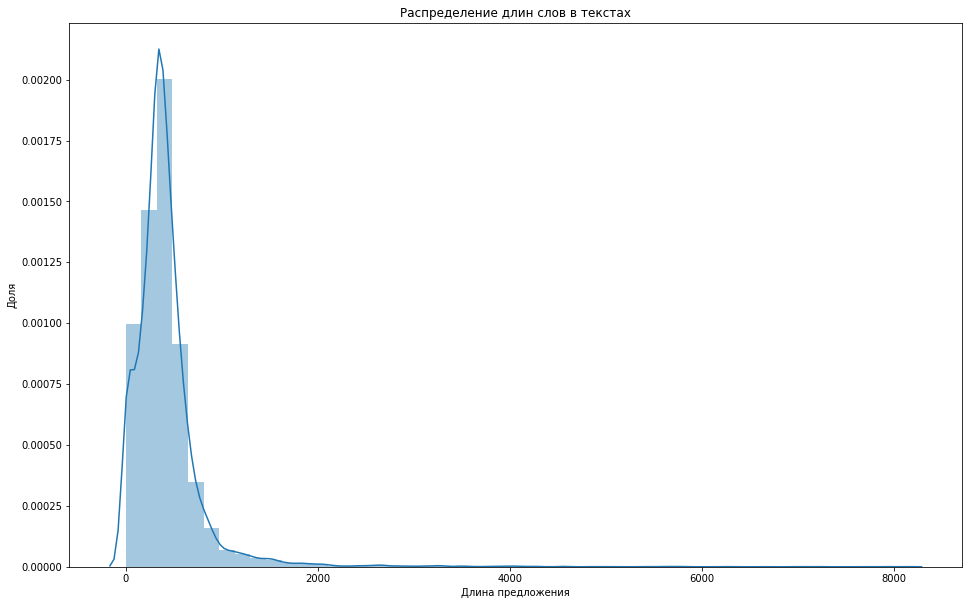

In [39]:
import seaborn as sns
from matplotlib import pyplot as plt

l = []
for text in news.text:
    l.append(len(text.split()))


plt.figure(figsize=(16, 10))
plt.title('Распределение длин слов в текстах')
plt.xlabel('Длина предложения')
plt.ylabel('Доля')
sns.distplot(l)

In [40]:
upper_threshold = 500
lower_threshold = 3

correct_percent = len([sent_len for sent_len in l 
                       if sent_len <= upper_threshold and sent_len >= lower_threshold]) * 100 / len(l)

'{:.2f} % наших текстов входят в промежуток от {} до {} слов'.format(correct_percent, lower_threshold, upper_threshold)

'71.21 % наших текстов входят в промежуток от 3 до 500 слов'

Оставим тексты длинной до 500 слов, иначе не хватает памяти

In [41]:
drop_ids = [i for i, x in enumerate(l) if x > 500]

In [42]:
news = news.drop(drop_ids)

In [43]:
len(news)

17467

##Word2vec инициализация

In [44]:
def split_text(text):
    return text.split()

In [45]:
texts = news.text.apply(split_text).tolist()

In [46]:
import gensim

w2v = gensim.models.Word2Vec(texts, size=300, window=5, min_count=1)

In [47]:
vocab = Counter()

for text in news['text']:
    vocab.update(text.split())

word2id = {'PAD':0}

for word in vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

In [48]:
weights = np.zeros((len(word2id), 300))
count = 0
for word, i in word2id.items():
    if word == 'PAD':
        continue   
    try:
        weights[i] = w2v.wv[word]    
    except KeyError:
      count += 1
      # oov словам сопоставляем случайный вектор
      weights[i] = np.random.uniform(-0.25,0.25,300)


## Датасеты и даталоадеры


Здесь я делаю паддинг, как они описывают: берется max_len на трэине и до этого значения паддятся все; если в тесте будет что-то длиннее max_len, оно обрезается по max_len. Однако так как я до этого обрезаю длину до 1000, то в этом как-то не остается смысла. При этом я оставлю потом возможность менять эту длину (типа для экспериментов с паддингом).

In [49]:
class NewsDataset(Dataset):

    def __init__(self, news, word2id, DEVICE, max_len=500):
        super().__init__()
        self.dataset = news['text'].values
        self.length = news.shape[0]
        self.target = news['label'].values
        self.device = DEVICE

        self.word2id = word2id
        self.max_len = max_len
        
        
    def __len__(self):
        return self.length

      
    def __getitem__(self, index): 
        words = self.dataset[index]
        ids = [self.word2id[word] for word in words.split() if word in self.word2id]
        ids = torch.LongTensor(ids+([0] * (self.max_len-len(ids))) if len(ids) <= self.max_len else ids[:self.max_len]).long()
        y = self.target[index]
        return ids, y


In [50]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
print(device)

cuda:0


##Модель и большие функции

(гипер)параметры:
- количество разных сверток с разными фильтрами, 
- размеры фильтров (список длины количество сверток),
- количество выходных каналов (список длины количество сверток),
- размер скрытого слоя в лстм, 
- количество лстм слоев
- дропаут либо до лстм, либо после, и его rate


In [51]:
def loop(train_iterator, test_iterator, model, optimizer, criterion, epochs):
    losses = []
    best_test_loss = 10.

    accuracy_test = []
    accuracy_train = []
    losses_test = []
    losses_train = []    

    for n_epoch in range(epochs):
        
        train_losses = []
        test_losses = []
        test_targets = []
        test_pred_class = []
        
        progress_bar = tqdm(total=len(train_iterator), desc='Epoch {}'.format(n_epoch + 1))
        
        model.train()
        
        for x, y in train_iterator:

            x = x.to(device)
            y = y.to(device)
            
            optimizer.zero_grad()
            
            pred = model(x)
            
            loss = criterion(pred, y)
            
            loss.backward()
            
            optimizer.step()
            
            train_losses.append(loss.item())
            losses.append(loss.item())
            
            progress_bar.set_postfix(train_loss = np.mean(losses[-500:]))

            progress_bar.update(x.shape[0])
            
        progress_bar.close()
        
        model.eval()
        
        for x, y in test_iterator:
            
            x = x.to(device)

            with torch.no_grad():

                pred = model(x)

                pred = pred.cpu()

                test_targets.append(y.numpy())
                test_pred_class.append(np.argmax(pred, axis=1))

                loss = criterion(pred, y)

                test_losses.append(loss.item())
            
        mean_test_loss = np.mean(test_losses)

        test_targets = np.concatenate(test_targets).squeeze()
        test_pred_class = np.concatenate(test_pred_class).squeeze()

        acc = accuracy_score(test_targets, test_pred_class)
        # acc = accuracy(test_targets.round().long(), test_pred_class.long(), ignore_index=0)

        accuracy_test.append(acc)
        
        print()
        print('Losses: train - {:.3f}, test - {:.3f}'.format(np.mean(train_losses), mean_test_loss))

        print('Accuracy test - {:.3f}'.format(acc))
            
        # # Early stopping:
        # if mean_test_loss < best_test_loss:
        #     best_test_loss = mean_test_loss
        # else:
        #     print('Early stopping')
        #     break
    return model, losses, accuracy_test

In [52]:
def learning_history_loss(losses):
    plt.title('CLSTM Training Process')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.grid()
    plt.plot(losses)
    plt.show()


In [53]:
def learning_history_acc(accs):
    plt.title('CLSTM Accuracy rates durig training')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.plot(accs)
    plt.show()


In [54]:
def define_max_len(texts):
    max_len_pad = 0
    for text in texts:
        if len(text.split()) > max_len_pad:
            max_len_pad = len(text.split())

    return max_len_pad

In [55]:
class CLSTM(nn.Module):
    def __init__(self, device, n_classes, weights, num_convs=1, filter_sizes=[3,], num_filters=[150,], hidden_dim=150, num_lstm_layers=1, dropout_after_lstm_rate=0, dropout_before_conv_rate=0):
        super().__init__()
        self.n = n_classes
        self.embed = nn.Embedding.from_pretrained(torch.Tensor(weights))
        self.conv = {}
        for i in range(num_convs):
            self.conv[i] = nn.Conv1d(in_channels=300, out_channels=num_filters[i], kernel_size=filter_sizes[i]).to(device)
            
        self.LSTM_layer = nn.LSTM(np.sum(np.array(num_filters)), hidden_dim, num_layers=num_lstm_layers, batch_first=True)

        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_dim, n_classes)
        self.dropout_after_lstm = nn.Dropout(p=dropout_after_lstm_rate)
        self.dropout_before_conv = nn.Dropout(p=dropout_before_conv_rate)

        
    
    def forward(self, words):
        embedded_words = self.embed(words)  #batchsize*seq_len*emb_dim  1024  sl  300
        embedded_words = self.dropout_before_conv(embedded_words)
        embedded_words = embedded_words.transpose(1, 2)  #1024  300  sl
        
        feat_maps = []
        for i in range(len(self.conv)):
            if feat_maps == []:
                feat_maps = self.relu(self.conv[i](embedded_words))   #1024  filter_size sl
            else:
                new_map = self.relu(self.conv[i](embedded_words))
                if new_map.shape[-1] >= feat_maps.shape[-1]:
                    new_map = new_map[:, :, :feat_maps.shape[-1]]
                else:
                    feat_maps = feat_maps[:, :, :new_map.shape[-1]]
                feat_maps = torch.cat((feat_maps, new_map), 1)  #1024  filter_sizes.sum sl
        
        feat_maps = feat_maps.transpose(1, 2)   #1024   sl    filter_sizes.sum

        output, (ht, ct) = self.LSTM_layer(feat_maps)     #1024   sl   hidden

        output = self.dropout_after_lstm(ht)

        logits = self.fc(ht[-1])  #batch*hidden
        return logits
        


In [56]:
def experiments(news, word2id, weights, device, batch_size=256, lr=0.001, epochs=10, 
                num_convs=1, filter_sizes=[3,], num_filters=[150,], hidden_dim=150, num_lstm_layers=1, 
                dropout_after_lstm_rate=0, dropout_before_conv_rate=0, weight_decay=0, max_len_pad=None):
    if max_len_pad:
        pass
    else:
        max_len_pad = define_max_len(news.text)


    train_data, test_data = train_test_split(news, test_size=0.2, random_state=40)

    train_dataset = NewsDataset(train_data, word2id, device, max_len_pad)
    train_sampler = RandomSampler(train_dataset)
    train_iterator = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

    test_dataset = NewsDataset(test_data, word2id, device, max_len_pad)
    test_sampler = SequentialSampler(test_dataset)
    test_iterator = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size)



    n_classes = 6
    model = CLSTM(device, n_classes, weights, num_convs, filter_sizes, 
              num_filters, hidden_dim, num_lstm_layers, dropout_after_lstm_rate, dropout_before_conv_rate )

    optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = torch.nn.CrossEntropyLoss()

    # веса модели и значения лосса храним там же, где и все остальные тензоры
    model = model.to(device)
    criterion = criterion.to(device)

    model, losses, accuracies = loop(train_iterator, test_iterator, model, optimizer, criterion, epochs)
    
    learning_history_loss(losses)
    learning_history_acc(accuracies)

    return model


##на случай лагов tqdm

In [81]:
for instance in list(tqdm._instances): 
    tqdm._decr_instances(instance)

##1 эксперимент

запустим с теми параметрами, с которыми модель в статье у авторов сработала лучше всего, то есть 1 сверточный слой с кернелом 3, выходных фильтров 150, входных слоев в лстм 150, weight_decay=0.001 и дропаут слои с вероятностью 0.5

Epoch 1: 13973it [00:23, 602.41it/s, train_loss=1.43]



Losses: train - 1.433, test - 1.434
Accuracy test - 0.383


Epoch 2: 13973it [00:23, 604.35it/s, train_loss=1.43]



Losses: train - 1.421, test - 1.435
Accuracy test - 0.383


Epoch 3: 13973it [00:23, 602.98it/s, train_loss=1.42]



Losses: train - 1.420, test - 1.437
Accuracy test - 0.383


Epoch 4: 13973it [00:23, 605.31it/s, train_loss=1.42]



Losses: train - 1.419, test - 1.428
Accuracy test - 0.383


Epoch 5: 13973it [00:23, 604.86it/s, train_loss=1.42]



Losses: train - 1.418, test - 1.434
Accuracy test - 0.383


Epoch 6: 13973it [00:23, 604.78it/s, train_loss=1.42]



Losses: train - 1.419, test - 1.436
Accuracy test - 0.383


Epoch 7: 13973it [00:23, 605.85it/s, train_loss=1.41]



Losses: train - 1.368, test - 1.343
Accuracy test - 0.516


Epoch 8: 13973it [00:23, 605.73it/s, train_loss=1.37]



Losses: train - 1.244, test - 1.530
Accuracy test - 0.401


Epoch 9: 13973it [00:23, 604.74it/s, train_loss=1.33]



Losses: train - 1.225, test - 1.265
Accuracy test - 0.464


Epoch 10: 13973it [00:23, 604.79it/s, train_loss=1.28]



Losses: train - 1.214, test - 1.420
Accuracy test - 0.412


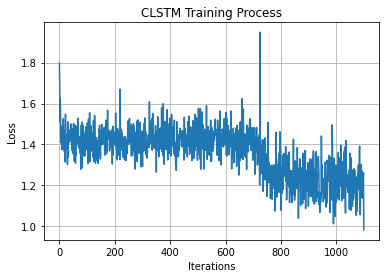

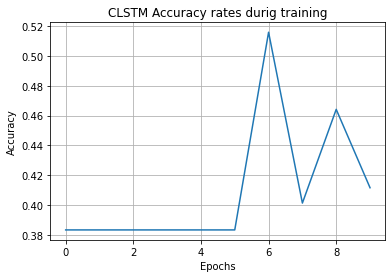

In [60]:
out = experiments(news, word2id, weights, device, batch_size=128, lr=0.001, epochs=10, num_convs=1, 
            filter_sizes=[3,], num_filters=[150,], hidden_dim=150, num_lstm_layers=1, 
            dropout_after_lstm_rate=0.5, dropout_before_conv_rate=0.5, weight_decay=0.001)

##2 эксперимент

Попробуем так же кернел 2, но уберем weight decay и уменьшим дропаут

Epoch 1: 13973it [00:22, 620.86it/s, train_loss=1.42]



Losses: train - 1.422, test - 1.308
Accuracy test - 0.547


Epoch 2: 13973it [00:22, 618.71it/s, train_loss=1.32]



Losses: train - 1.208, test - 0.908
Accuracy test - 0.666


Epoch 3: 13973it [00:22, 619.72it/s, train_loss=1.16]



Losses: train - 0.836, test - 0.810
Accuracy test - 0.679


Epoch 4: 13973it [00:22, 618.40it/s, train_loss=1.08]



Losses: train - 0.844, test - 0.818
Accuracy test - 0.677


Epoch 5: 13973it [00:22, 619.02it/s, train_loss=0.98]



Losses: train - 0.800, test - 1.113
Accuracy test - 0.614


Epoch 6: 13973it [00:22, 620.50it/s, train_loss=0.858]



Losses: train - 0.794, test - 0.806
Accuracy test - 0.680


Epoch 7: 13973it [00:22, 610.84it/s, train_loss=0.808]



Losses: train - 0.790, test - 0.832
Accuracy test - 0.676


Epoch 8: 13973it [00:22, 620.39it/s, train_loss=0.802]



Losses: train - 0.814, test - 0.837
Accuracy test - 0.674


Epoch 9: 13973it [00:22, 620.87it/s, train_loss=0.798]



Losses: train - 0.793, test - 0.812
Accuracy test - 0.679


Epoch 10: 13973it [00:22, 620.21it/s, train_loss=0.792]



Losses: train - 0.782, test - 0.800
Accuracy test - 0.621


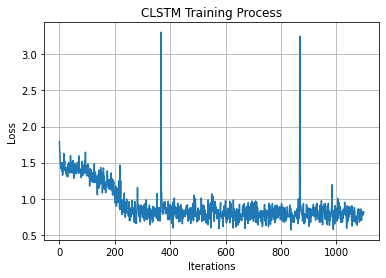

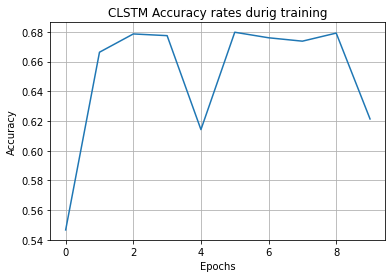

In [61]:
out = experiments(news, word2id, weights, device, batch_size=128, lr=0.001, epochs=10, num_convs=1, 
            filter_sizes=[2,], num_filters=[150,], hidden_dim=150, num_lstm_layers=1, 
            dropout_after_lstm_rate=0.1, dropout_before_conv_rate=0.1)

##3 эксперимент

возьмем кернел 4, уберем дропауты совсем

Epoch 1: 13973it [00:23, 599.34it/s, train_loss=1.47]



Losses: train - 1.468, test - 1.441
Accuracy test - 0.383


Epoch 2: 13973it [00:23, 596.01it/s, train_loss=1.4]



Losses: train - 1.326, test - 1.313
Accuracy test - 0.559


Epoch 3: 13973it [00:23, 597.67it/s, train_loss=1.24]



Losses: train - 0.916, test - 0.826
Accuracy test - 0.673


Epoch 4: 13973it [00:23, 597.03it/s, train_loss=1.13]



Losses: train - 0.828, test - 0.834
Accuracy test - 0.563


Epoch 5: 13973it [00:23, 595.84it/s, train_loss=1.03]



Losses: train - 0.822, test - 0.817
Accuracy test - 0.677


Epoch 6: 13973it [00:23, 595.19it/s, train_loss=0.893]



Losses: train - 0.792, test - 0.829
Accuracy test - 0.680


Epoch 7: 13973it [00:23, 594.30it/s, train_loss=0.816]



Losses: train - 0.802, test - 0.838
Accuracy test - 0.678


Epoch 8: 13973it [00:23, 590.70it/s, train_loss=0.801]



Losses: train - 0.783, test - 0.822
Accuracy test - 0.679


Epoch 9: 13973it [00:23, 597.23it/s, train_loss=0.792]



Losses: train - 0.772, test - 0.737
Accuracy test - 0.620


Epoch 10: 13973it [00:23, 598.17it/s, train_loss=0.769]



Losses: train - 0.708, test - 0.710
Accuracy test - 0.680


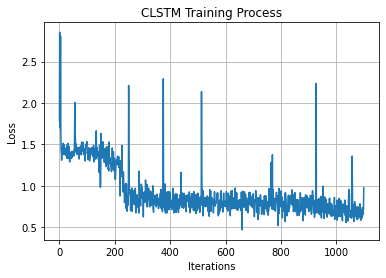

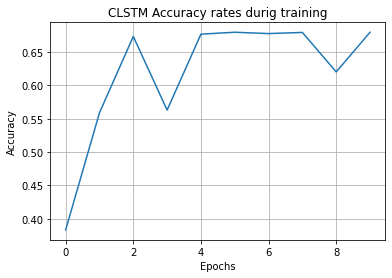

In [62]:
out = experiments(news, word2id, weights, device, batch_size=128, lr=0.005, epochs=10, num_convs=1, 
            filter_sizes=[4,], num_filters=[150,], hidden_dim=150, num_lstm_layers=1)

Судя по лоссу лучше всего обучается совсем без регуляризации и с большим размером фильтра. По аккьюраси лучше всего вторая модель с небольшой вероятностью дропаута. Оставим небольшой дропаут для последующих экспериментов

##4 эксперимент


теперь попробуем с 2 сверточными слоями. 

Epoch 1: 13973it [00:29, 469.28it/s, train_loss=1.52]



Losses: train - 1.516, test - 1.251
Accuracy test - 0.557


Epoch 2: 13973it [00:29, 475.26it/s, train_loss=1.44]



Losses: train - 1.365, test - 1.428
Accuracy test - 0.383


Epoch 3: 13973it [00:29, 475.85it/s, train_loss=1.42]



Losses: train - 1.382, test - 1.268
Accuracy test - 0.553


Epoch 4: 13973it [00:29, 472.11it/s, train_loss=1.38]



Losses: train - 1.256, test - 1.253
Accuracy test - 0.552


Epoch 5: 13973it [00:29, 477.43it/s, train_loss=1.33]



Losses: train - 1.125, test - 0.838
Accuracy test - 0.668


Epoch 6: 13973it [00:29, 474.61it/s, train_loss=1.24]



Losses: train - 0.804, test - 0.813
Accuracy test - 0.679


Epoch 7: 13973it [00:29, 475.46it/s, train_loss=1.18]



Losses: train - 0.800, test - 0.816
Accuracy test - 0.680


Epoch 8: 13973it [00:29, 476.75it/s, train_loss=1.13]



Losses: train - 0.797, test - 0.857
Accuracy test - 0.675


Epoch 9: 13973it [00:29, 479.07it/s, train_loss=1.09]



Losses: train - 0.790, test - 0.805
Accuracy test - 0.681


Epoch 10: 13973it [00:29, 476.65it/s, train_loss=1.01]



Losses: train - 0.789, test - 0.821
Accuracy test - 0.679


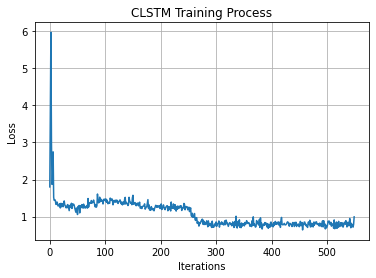

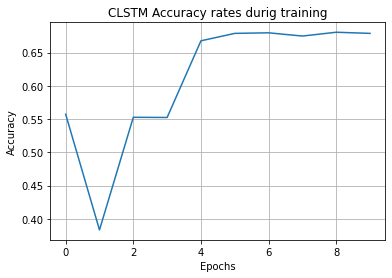

In [74]:
out = experiments(news, word2id, weights, device, batch_size=256, lr=0.01, epochs=10, num_convs=2, 
            filter_sizes=[2,3], num_filters=[250, 150], hidden_dim=150, num_lstm_layers=1, 
            dropout_after_lstm_rate=0.1, dropout_before_conv_rate=0.1)

##5 эксперимент

возьмем 2 слоя и побольше кернелы

Epoch 1: 13973it [00:25, 558.17it/s, train_loss=1.49]



Losses: train - 1.490, test - 1.423
Accuracy test - 0.383


Epoch 2: 13973it [00:25, 554.79it/s, train_loss=1.46]



Losses: train - 1.429, test - 1.424
Accuracy test - 0.407


Epoch 3: 13973it [00:25, 538.11it/s, train_loss=1.43]



Losses: train - 1.363, test - 1.303
Accuracy test - 0.548


Epoch 4: 13973it [00:25, 546.40it/s, train_loss=1.39]



Losses: train - 1.292, test - 1.368
Accuracy test - 0.448


Epoch 5: 13973it [00:24, 560.30it/s, train_loss=1.31]



Losses: train - 0.994, test - 0.828
Accuracy test - 0.679


Epoch 6: 13973it [00:25, 544.78it/s, train_loss=1.23]



Losses: train - 0.810, test - 0.819
Accuracy test - 0.679


Epoch 7: 13973it [00:25, 554.70it/s, train_loss=1.17]



Losses: train - 0.797, test - 0.807
Accuracy test - 0.680


Epoch 8: 13973it [00:25, 557.34it/s, train_loss=1.12]



Losses: train - 0.793, test - 0.855
Accuracy test - 0.675


Epoch 9: 13973it [00:25, 554.81it/s, train_loss=1.09]



Losses: train - 0.832, test - 0.816
Accuracy test - 0.679


Epoch 10: 13973it [00:25, 554.97it/s, train_loss=1.02]



Losses: train - 0.794, test - 0.810
Accuracy test - 0.679


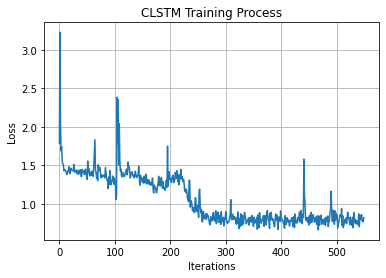

Epoch 8: 7168it [05:20, 22.36it/s, train_loss=1.52] 


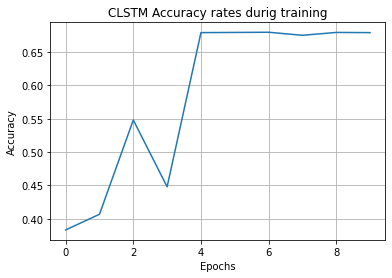

In [78]:
out = experiments(news, word2id, weights, device, batch_size=256, lr=0.005, epochs=10, num_convs=2, 
            filter_sizes=[3,4], num_filters=[150, 100], hidden_dim=150, num_lstm_layers=1, 
            dropout_after_lstm_rate=0.1, dropout_before_conv_rate=0.1)

##6 эксперимент

теперь попробуем с 3 сверточными слоями. 

In [68]:
for instance in list(tqdm._instances): 
    tqdm._decr_instances(instance)

Epoch 1: 13973it [00:38, 360.52it/s, train_loss=1.4]



Losses: train - 1.399, test - 1.241
Accuracy test - 0.554


Epoch 2: 13973it [00:36, 380.31it/s, train_loss=1.2]



Losses: train - 0.998, test - 0.813
Accuracy test - 0.679


Epoch 3: 13973it [00:36, 378.80it/s, train_loss=1.06]



Losses: train - 0.794, test - 0.802
Accuracy test - 0.680


Epoch 4: 13973it [00:36, 381.15it/s, train_loss=0.998]



Losses: train - 0.801, test - 0.800
Accuracy test - 0.681


Epoch 5: 13973it [00:36, 378.69it/s, train_loss=0.955]



Losses: train - 0.783, test - 0.796
Accuracy test - 0.681


Epoch 6: 13973it [00:36, 381.08it/s, train_loss=0.926]



Losses: train - 0.784, test - 0.807
Accuracy test - 0.682


Epoch 7: 13973it [00:36, 381.30it/s, train_loss=0.906]



Losses: train - 0.783, test - 0.788
Accuracy test - 0.680


Epoch 8: 13973it [00:36, 382.53it/s, train_loss=0.889]



Losses: train - 0.767, test - 1.131
Accuracy test - 0.463


Epoch 9: 13973it [00:36, 383.45it/s, train_loss=0.871]



Losses: train - 0.729, test - 0.695
Accuracy test - 0.697


Epoch 10: 13973it [00:36, 380.57it/s, train_loss=0.799]



Losses: train - 0.708, test - 0.660
Accuracy test - 0.701


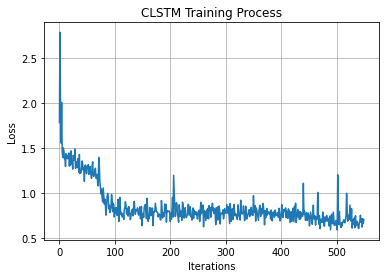

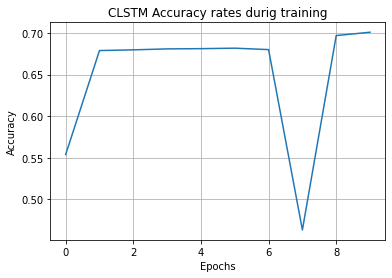

In [63]:
out = experiments(news, word2id, weights, device, batch_size=256, lr=0.005, epochs=10, num_convs=3, 
            filter_sizes=[2,3,4], num_filters=[250, 150, 100], hidden_dim=150, num_lstm_layers=1, 
            dropout_after_lstm_rate=0.1, dropout_before_conv_rate=0.1)

##7 эксперимент

попробуем добавить слоев в лстм

Epoch 1: 13973it [00:32, 432.63it/s, train_loss=1.44]



Losses: train - 1.436, test - 1.455
Accuracy test - 0.305


Epoch 2: 13973it [00:32, 426.87it/s, train_loss=1.43]



Losses: train - 1.420, test - 1.406
Accuracy test - 0.446


Epoch 3: 13973it [00:32, 433.10it/s, train_loss=1.37]



Losses: train - 1.256, test - 1.233
Accuracy test - 0.550


Epoch 4: 13973it [00:32, 433.97it/s, train_loss=1.28]



Losses: train - 1.023, test - 0.865
Accuracy test - 0.563


Epoch 5: 13973it [00:32, 435.83it/s, train_loss=1.17]



Losses: train - 0.822, test - 0.820
Accuracy test - 0.678


Epoch 6: 13973it [00:32, 435.35it/s, train_loss=1.03]



Losses: train - 0.794, test - 0.800
Accuracy test - 0.679


Epoch 7: 13973it [00:32, 432.08it/s, train_loss=0.899]



Losses: train - 0.787, test - 0.806
Accuracy test - 0.647


Epoch 8: 13973it [00:32, 432.89it/s, train_loss=0.812]



Losses: train - 0.792, test - 0.794
Accuracy test - 0.679


Epoch 9: 13973it [00:31, 436.98it/s, train_loss=0.795]



Losses: train - 0.799, test - 0.797
Accuracy test - 0.680


Epoch 10: 13973it [00:31, 443.97it/s, train_loss=0.788]



Losses: train - 0.772, test - 0.788
Accuracy test - 0.680


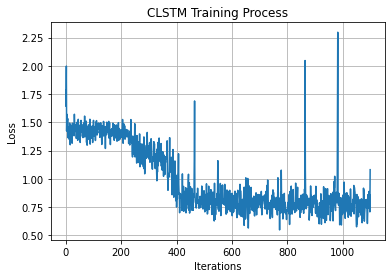

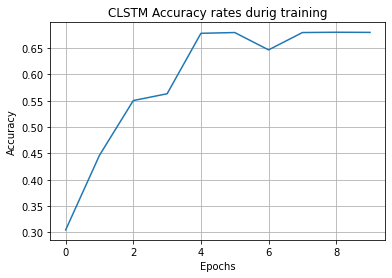

In [85]:
out = experiments(news, word2id, weights, device, batch_size=128, lr=0.001, epochs=10, num_convs=1, 
            filter_sizes=[3], num_filters=[200], hidden_dim=150, num_lstm_layers=2, 
            dropout_after_lstm_rate=0.1, dropout_before_conv_rate=0.1)

##8 эксперимент

попробуем изменить размер выходного слоя лстм

Epoch 1: 13973it [00:59, 233.69it/s, train_loss=1.43]



Losses: train - 1.427, test - 1.251
Accuracy test - 0.557


Epoch 2: 13973it [00:58, 238.29it/s, train_loss=1.33]



Losses: train - 1.230, test - 1.125
Accuracy test - 0.635


Epoch 3: 13973it [00:59, 235.41it/s, train_loss=1.19]



Losses: train - 0.928, test - 0.809
Accuracy test - 0.679


Epoch 4: 13973it [00:59, 234.27it/s, train_loss=1.1]



Losses: train - 0.818, test - 1.046
Accuracy test - 0.573


Epoch 5: 13973it [01:00, 231.25it/s, train_loss=0.995]



Losses: train - 0.800, test - 0.811
Accuracy test - 0.681


Epoch 6: 13973it [00:59, 233.93it/s, train_loss=0.879]



Losses: train - 0.789, test - 0.812
Accuracy test - 0.679


Epoch 7: 13973it [00:58, 240.21it/s, train_loss=0.812]



Losses: train - 0.828, test - 0.807
Accuracy test - 0.679


Epoch 8: 13973it [00:58, 239.80it/s, train_loss=0.808]



Losses: train - 0.802, test - 0.821
Accuracy test - 0.609


Epoch 9: 13973it [00:58, 239.75it/s, train_loss=0.803]



Losses: train - 0.799, test - 0.800
Accuracy test - 0.679


Epoch 10: 13973it [00:58, 240.14it/s, train_loss=0.797]



Losses: train - 0.765, test - 0.734
Accuracy test - 0.680


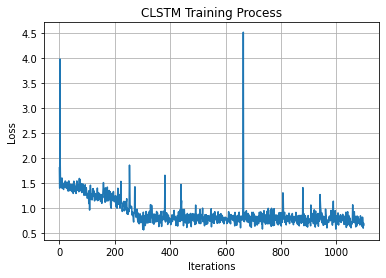

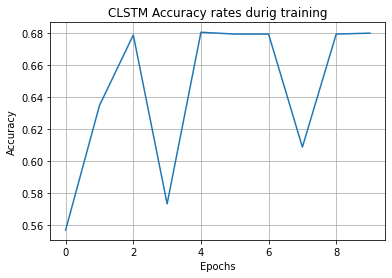

In [86]:
out = experiments(news, word2id, weights, device, batch_size=128, lr=0.001, epochs=10, num_convs=1, 
            filter_sizes=[3], num_filters=[300], hidden_dim=300, num_lstm_layers=2, 
            dropout_after_lstm_rate=0.1, dropout_before_conv_rate=0.1)

##9 эксперимент

3 свертки с разными окнами и 2 слоя лстм

Epoch 1: 13973it [00:43, 319.05it/s, train_loss=1.5]



Losses: train - 1.503, test - 1.345
Accuracy test - 0.559


Epoch 2: 13973it [00:42, 328.37it/s, train_loss=1.43]



Losses: train - 1.357, test - 1.537
Accuracy test - 0.383


Epoch 3: 13973it [00:42, 326.08it/s, train_loss=1.38]



Losses: train - 1.273, test - 1.251
Accuracy test - 0.554


Epoch 4: 13973it [00:42, 325.40it/s, train_loss=1.34]



Losses: train - 1.232, test - 0.988
Accuracy test - 0.631


Epoch 5: 13973it [00:42, 327.38it/s, train_loss=1.26]



Losses: train - 0.914, test - 0.833
Accuracy test - 0.678


Epoch 6: 13973it [00:42, 327.34it/s, train_loss=1.18]



Losses: train - 0.800, test - 0.812
Accuracy test - 0.680


Epoch 7: 13973it [00:42, 326.65it/s, train_loss=1.12]



Losses: train - 0.792, test - 0.833
Accuracy test - 0.611


Epoch 8: 13973it [00:42, 327.64it/s, train_loss=1.09]



Losses: train - 0.881, test - 0.806
Accuracy test - 0.679


Epoch 9: 13973it [00:42, 327.61it/s, train_loss=1.06]



Losses: train - 0.787, test - 0.807
Accuracy test - 0.680


Epoch 10: 13973it [00:42, 326.93it/s, train_loss=0.986]



Losses: train - 0.790, test - 0.808
Accuracy test - 0.679


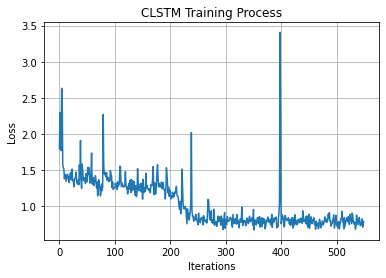

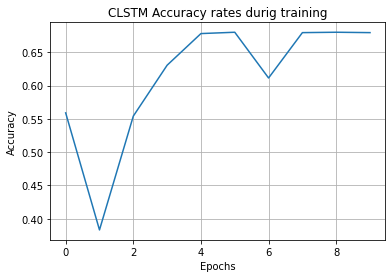

In [82]:
out = experiments(news, word2id, weights, device, batch_size=256, lr=0.005, epochs=10, num_convs=3, 
            filter_sizes=[2,3,4], num_filters=[250, 150, 100], hidden_dim=150, num_lstm_layers=2, 
            dropout_after_lstm_rate=0.1, dropout_before_conv_rate=0.1)

##Анализ

Во-первых, заметно, что чрезмерная регуляризация, как в 1 эксперименте, сильно портит модель. Из-за слишком большого дропаута она обучилась хуже всего. Однако при полном отсутствии регуляризации результаты выходили хуже. Оптимальным мне показалось значение до 0.1, потому что при большем модель могла либо вообще перестать обучаться на определенном этапе (причем лосс в районе 1.4), либо обучиться, но с меньшим качеством. 



Во-вторых, добавление сверточных слоев улучшило качество, что не совпадает с результатами авторов статьи (хотя совпадает с их ожиданиями). 

В-третьих, увеличение количества лстм слоев, наоборот, не помогает, никак не помогло так же изменение выходного слоя лстм или размера фильтра.



Для моделей я меняла lr от 0.005 до 0.001, но это тоже не сильно влияло. Почти у всех моделей лучшее качество варьируется от 0.65 до 0.68 (и тут будто граница на 0.68). Лучше всего сработала модель с 3 свертками размеров 2,3,4 и 1 лстм слоем, с дропаут вероятностью 0.1 - аккьюраси около 0.7